# Fit with a conversion of nv

In [1]:
import sys
sys.path.append('C:\\Users\\MHJGuillermo\\PycharmProjects\\Doctorado\\Ising\\Varios_vecinos\\venv\\src')

In [2]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
import style
from ising.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.optimize import curve_fit
from scipy.optimize import least_squares, differential_evolution, minimize
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


## Model
El modelo a utilizar es:
$$ \frac{1}{\exp(\frac{1}{T})^2} = a_1 +a_2*x$$ 

In [3]:
def model_function(x: float,a1,a2):
    return a1+a2*x

In [4]:
def get_extrapol_function(model_function,a1,a2):
    def extrapol_funct(x):
        return model_function(x,a1,a2)
    return extrapol_funct

## Read files

In [5]:
data_path = Path("../../../data/h-1").resolve()
file = 'all_inv_Tc_h-1.csv'
df_all_tc = pd.read_csv(os.path.join(data_path,file))

In [6]:
df_all_tc

,1/nv,P2.0
0,1.000000,0.482330
1,0.500000,0.407525
2,0.333333,0.378513
3,0.250000,0.362943
4,0.200000,0.353541
5,0.166667,0.346949
6,0.142857,0.342308
7,0.125000,0.338823
8,0.111111,0.336042
9,0.100000,0.333850


In [7]:
df_params = pd.DataFrame(index=["a1","a2"])
df_extrapol_val = pd.DataFrame(index=["infty","1"])

Save graph C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\graphs\h-1\inv_Tc_vs_inv_nv_sqrt_and_log_2_parms_h-1_P2.0.png


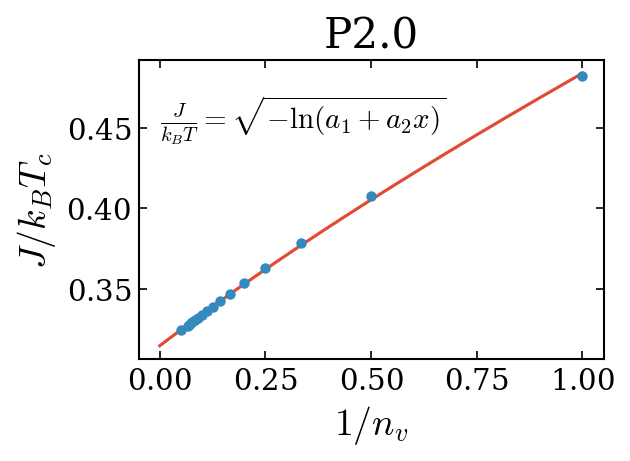

a1: 0.9057401993476031
a2: -0.11444454681510353
Extrapolation:
0.3146470558394017 at 1/nv=0
0.4838218788610173 at 1/nv=1
min:0.7912956525324996 at 1.0




In [9]:
COLUMNS = ["P2.0"]
path_save_graph = Path("../../../graphs/h-1").resolve()
file_name_base = 'inv_Tc_vs_inv_nv_sqrt_and_log_2_parms_h-1'
for COLUMN in COLUMNS:
    file_graph = file_name_base + '_{}.png'.format(COLUMN)
    # Get the data in arrays
    df_part = df_all_tc[["1/nv",COLUMN]]
    df_part = df_part.dropna()
    x_data = df_part['1/nv'].values
    y_data = df_part[COLUMN].values

    # transform data
    y_data = 1/np.exp((y_data**2))    

    # fit 
    (a1,a2), _= curve_fit(f=model_function,xdata=x_data,ydata=y_data,maxfev=10000,p0=[1, 0.5],
                               bounds=([0, -10], [1, 10]))
    df_params[COLUMN] = [a1,a2]
    extrapol_funct = get_extrapol_function(model_function, a1,a2)

    # define the point for graph
    x_extrapol = np.linspace(0, 1, 2048)
    y_extrapol = extrapol_funct(x_extrapol)

    # Load the default style.
    style.use("default")
    rcParams["text.usetex"] = False

    fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
    grid_spec = GridSpec(3, 1)

    # Specific heat subplot.
    ax: Axes = fig1.add_subplot(grid_spec[0, 0])

    ax.plot(x_extrapol, np.sqrt(-np.log(y_extrapol)), lw=1.5)
    ax.plot(x_data, np.sqrt(-np.log(y_data)), marker="o", lw=0)

    ax.set_xlabel(r"$1/n_v$")
    ax.set_ylabel(r"$J/k_BT_c$")
    # add text
    ax.text(0, 0.45, r"$\frac{J}{k_BT} =  \sqrt{-\ln{(a_1+a_2x)}}$")

    ax.set_title(COLUMN)
    pyplot.draw()
    print('Save graph {}'.format(os.path.join(path_save_graph,file_graph)))
    pyplot.savefig(os.path.join(path_save_graph,file_graph))
    pyplot.show()
    print("a1: {}\na2: {}".format(a1,a2))
    print("Extrapolation:\n{} at 1/nv=0\n{} at 1/nv=1".format(
                                                            np.sqrt(-np.log(extrapol_funct(0))),
                                                            np.sqrt(-np.log(extrapol_funct(1))))
         )
    df_extrapol_val[COLUMN] = [np.sqrt(-np.log(extrapol_funct(0))),np.sqrt(-np.log(extrapol_funct(1)))]  
    print("min:{} at {}".format(np.nanmin(y_extrapol),x_extrapol[np.nanargmin(y_extrapol)]))    
    print("\n")

## Save params

In [12]:
# Define tha path and name for the csv files
file_params = os.path.join(data_path,'Extrapolation',file_name_base+'_params_curves.csv')
file_extrapol_values = os.path.join(data_path,'Extrapolation',file_name_base+'_extrapol_values.csv')
print(df_params)
print("Exporting to csv files the params adjusted {}".format(file_params))
df_params.to_csv(file_params)
print(df_extrapol_val)
print("Exporting to csv files the extrapolation values adjusted {}".format(file_extrapol_values))
df_extrapol_val.to_csv(file_extrapol_values)

        P2.0
a1  0.905740
a2 -0.114445
Exporting to csv files the params adjusted C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\data\h-1\Extrapolation\inv_Tc_vs_inv_nv_sqrt_and_log_2_parms_h-1_params_curves.csv
           P2.0
infty  0.314647
1      0.483822
Exporting to csv files the extrapolation values adjusted C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\data\h-1\Extrapolation\inv_Tc_vs_inv_nv_sqrt_and_log_2_parms_h-1_extrapol_values.csv


## Plot extrapol values

Save graph C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\graphs\Extrapolation\inv_Tc_vs_inv_nv_sqrt_and_log_3_parms_all_p.png


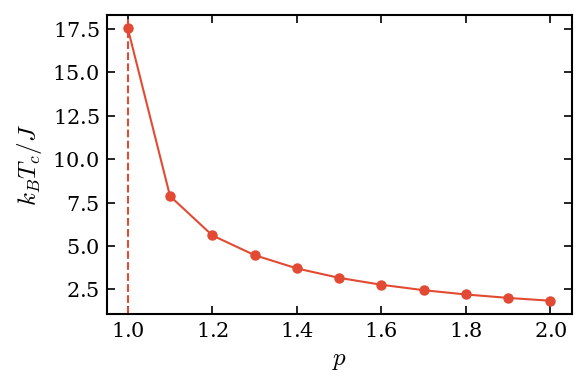

In [39]:
file_extrapol_graph = os.path.join(path_save_graph,'Extrapolation',file_name_base+'_all_p.png')
# data 
x_data = np.arange(1,2.1,0.1)
y_data = 1/df_extrapol_val.loc['infty'].values

# x_data = np.delete(x_data,0)
# y_data = np.delete(y_data, 0)
# # data for squared 
# y_data = np.sqrt(y_data)

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(x_data, y_data, marker="o", lw=1)

ax.set_xlabel(r"$p$")
ax.set_ylabel(r"$k_BT_c/J$")
ax.axvline(x=1,linestyle='--')

pyplot.draw()

print('Save graph {}'.format(file_extrapol_graph))
pyplot.savefig(file_extrapol_graph)

pyplot.show()